# Basket CDS Pricing: k-th to Default

CQF Final Project - Pricing a 5th-to-default basket CDS using copula models.

## 1. Setup & Imports

In [277]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, t

# Local modules
from src import (
    BootStrapper,
    GaussianCopula,
    TCopula,
    CDSPricing,
    RNGEngine,
    time_to_default,
    kth_to_default_df,
    calc_ecdf,
    plot_scatter_matrix,
    rank_to_uniform,
)
import src.config as config

In [278]:
# For development: auto-reload modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Parameters

In [279]:
# Experiment parameters (vary these per run)
# DATA_MODE: 'real' or 'synthetic'
DATA_MODE = 'real'
# CORR_LEVEL: 'high' or 'low'
CORR_LEVEL = 'high'
# SPREAD_MEASURE: 'delta' or 'level'
SPREAD_MEASURE = 'delta'
# K: k-th to default (1-5)
K = 5
# RNG_METHOD: 'pseudo', 'pseudo_antithetic', 'halton', 'sobol'
RNG_METHOD = 'sobol'
# COPULA: 'gaussian' or 't'
COPULA = 't'
# Degrees of freedom override for t-copula (None = estimate via MLE)
DF_OVERRIDE = None
# N_SIMS: config default, or override with integer
N_SIMS = 100_000
# Other parameters - set from config defaults
RECOVERY_RATE = config.DEFAULT_RECOVERY_RATE
TERM = config.DEFAULT_TERM
SEED = config.DEFAULT_SEED
# Where to output figures for reports
FIG_OUTPUT_DIR = 'figs_for_report'

In [280]:
print(f"DATA_MODE: {DATA_MODE}")
print(f"CORR_LEVEL: {CORR_LEVEL}")
print(f"SPREAD_MEASURE: {SPREAD_MEASURE}")
print(f"K-th to default: {K}")
print(f"N_SIMS: {N_SIMS:,}")
print(f"Recovery Rate: {RECOVERY_RATE:.0%}")
print(f"Term: {TERM}Y")
print(f"Seed: {SEED}")
print(f"RNG Method: {RNG_METHOD}")

DATA_MODE: real
CORR_LEVEL: high
SPREAD_MEASURE: delta
K-th to default: 5
N_SIMS: 100,000
Recovery Rate: 40%
Term: 5.0Y
Seed: 42
RNG Method: sobol


In [281]:
# Initialize RNG engine
rng = RNGEngine(method=RNG_METHOD, seed=SEED)
print(rng)

RNGEngine(method='sobol', seed=42)


In [282]:
# Tickers from config
tickers_dict = config.TICKERS[DATA_MODE][CORR_LEVEL]
tickers = list(tickers_dict.values())
print(f"Entities: {tickers}")

Entities: ['JPM', 'BAC', 'C', 'GS', 'MS']


## 3. Data Loading

In [283]:
# Load historical spread data -- NOTE: equity price data is used a proxy for CDS spreads when DATA_MODE='real'
hist_path = config.DATA_PATHS[DATA_MODE]['historical']

cds_levels_df = (
    pd.read_csv(hist_path)
    .loc[lambda df: df['ticker'].isin(tickers)]
)
cds_levels_df['date'] = pd.to_datetime(cds_levels_df['date'])
cds_levels_df = cds_levels_df.sort_values(['ticker', 'date'])

# Compute log returns (as proxy to spread changes)
col_name_level = config.FIELD_MAP[DATA_MODE]['level']
col_name_delta = config.FIELD_MAP[DATA_MODE]['delta']
cds_levels_df[col_name_delta] = np.log(
    cds_levels_df[col_name_level] / 
    cds_levels_df.groupby('ticker')[col_name_level].shift(1)
)
cds_levels_df = cds_levels_df.dropna(subset=[col_name_delta])

print(f"Date range: {cds_levels_df['date'].min()} to {cds_levels_df['date'].max()}")
display(cds_levels_df.head())

Date range: 2024-01-23 00:00:00 to 2026-01-16 00:00:00


,date,reference_entity,ticker,sector,adjusted_close,log_return
501,2024-01-23,Bank of America,BAC,Financials,31.23,0.006747
502,2024-01-24,Bank of America,BAC,Financials,31.43,0.006384
503,2024-01-25,Bank of America,BAC,Financials,31.82,0.012332
504,2024-01-26,Bank of America,BAC,Financials,31.86,0.001256
505,2024-01-29,Bank of America,BAC,Financials,32.03,0.005322


In [284]:
# Pivot to wide format
value_col = config.FIELD_MAP[DATA_MODE][SPREAD_MEASURE]

cds_df = cds_levels_df.pivot(
    index='date',
    columns='ticker',
    values=value_col
)[tickers]  # Ensure consistent column order

print(f"Shape: {cds_df.shape}")
display(cds_df.head())

Shape: (499, 5)


ticker,JPM,BAC,C,GS,MS
date,,,,,
2024-01-23,-0.006649,0.006747,0.008637,-0.013522,0.011738
2024-01-24,0.008917,0.006384,-0.000800,-0.003602,0.009536
2024-01-25,0.014224,0.012332,0.008768,0.008667,0.005097
2024-01-26,-0.003810,0.001256,-0.000993,-0.012918,-0.003274
2024-01-29,0.002602,0.005322,0.008110,0.007304,-0.001215


## 4. Exploratory Data Analysis

**Note that the computation of historical correlations and copula calibration are based on equity data even though the variable names might indicate that they are CDS sprads**

**Daily Log Returns are proxy to CDS Deltas, while Daily Share Prices are proxy to CDS Levels**

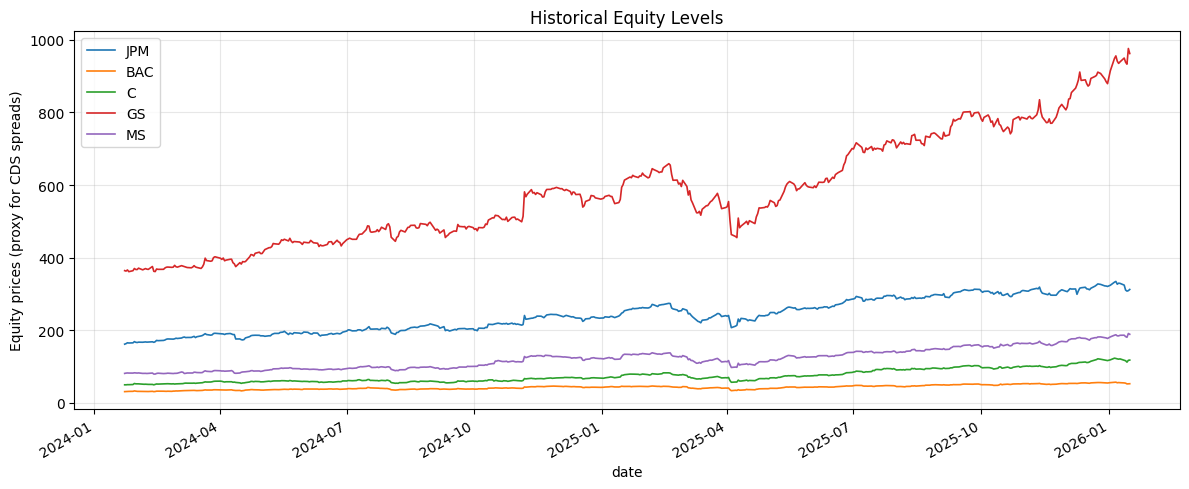

In [285]:
# Historical spread time series
cds_levels_wide = cds_levels_df.pivot(
    index='date',
    columns='ticker',
    values=col_name_level
)[tickers]

fig, ax = plt.subplots(figsize=(12, 5))
cds_levels_wide.plot(ax=ax, linewidth=1.2)
ax.set_ylabel('Equity prices (proxy for CDS spreads)')
ax.set_title('Historical Equity Levels')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"output/{FIG_OUTPUT_DIR}/equity_prices.png", dpi=150)
plt.show()

In [286]:
# Raw spread statistics
cds_df.describe()

# Save to csv
cds_df.to_csv(f"output/{FIG_OUTPUT_DIR}/raw_spread_statistics.csv")

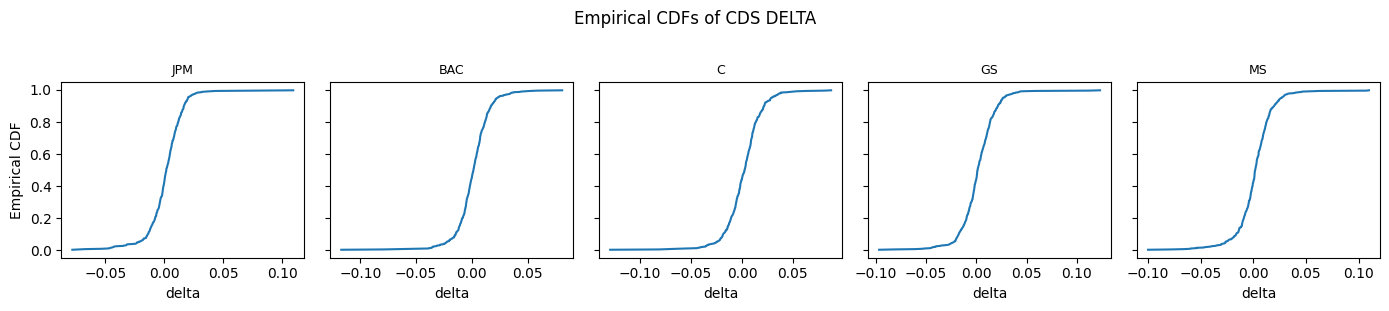

In [287]:
# Empirical CDFs
fig, axes = plt.subplots(1, len(tickers), figsize=(14, 3), sharey=True)

for ax, col in zip(axes, tickers):
    x_sorted, y_vals = calc_ecdf(cds_df[col])
    ax.plot(x_sorted, y_vals)
    ax.set_title(col, fontsize=9)
    ax.set_xlabel(SPREAD_MEASURE)

axes[0].set_ylabel('Empirical CDF')
fig.suptitle(f'Empirical CDFs of CDS {SPREAD_MEASURE.upper()}', y=1.02)
plt.savefig(f"output/{FIG_OUTPUT_DIR}/ecdf_cds_{SPREAD_MEASURE}.png", dpi=150)
plt.tight_layout()
plt.show()

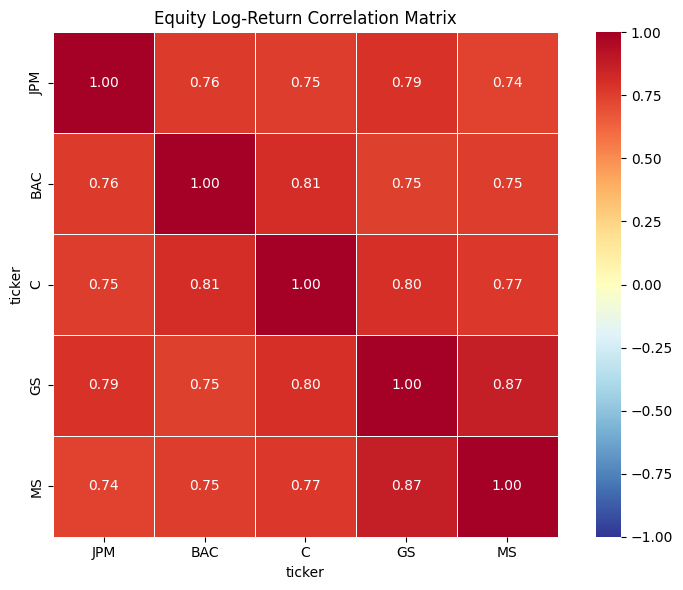

In [288]:
# Raw correlation
cds_corr_df = cds_df.corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    cds_corr_df,
    annot=True,
    fmt=".2f",
    cmap="RdYlBu_r",
    center=0,
    vmin=-1,
    vmax=1,
    square=True,
    linewidths=0.5,
    ax=ax
)
ax.set_title("Equity Log-Return Correlation Matrix")
plt.tight_layout()
plt.savefig(f"output/{FIG_OUTPUT_DIR}/correlation_heatmap.png", dpi=150)
plt.show()

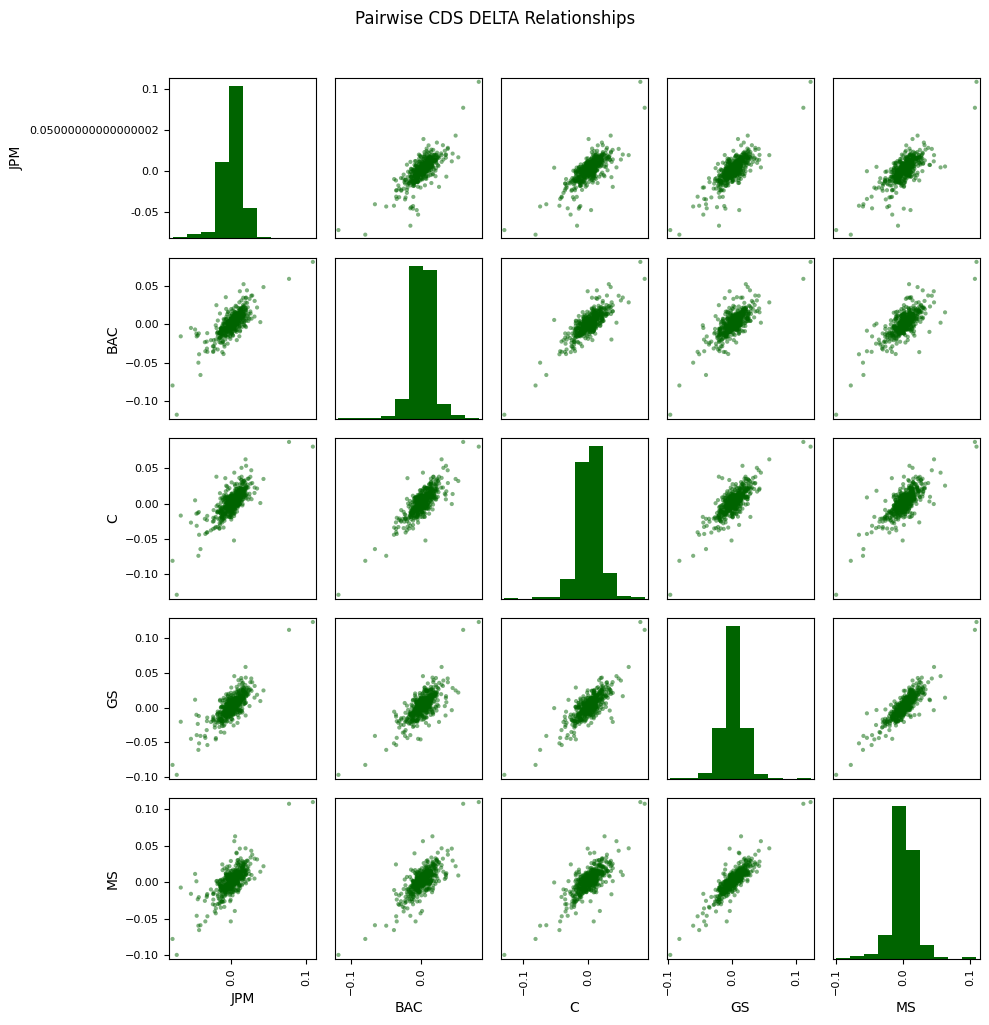

In [289]:
# Scatter matrix of raw spreads
plot_scatter_matrix(cds_df, title=f'Pairwise CDS {SPREAD_MEASURE.upper()} Relationships')

## 5. Copula Calibration

In [290]:
# Transform to uniform marginals via rank transformation
u_df = rank_to_uniform(cds_df)

# Drop rows with any NaN (need complete observations for copula)
u_joint_df = u_df.dropna(axis=0)
print(f"Complete observations: {len(u_joint_df)}")

Complete observations: 499


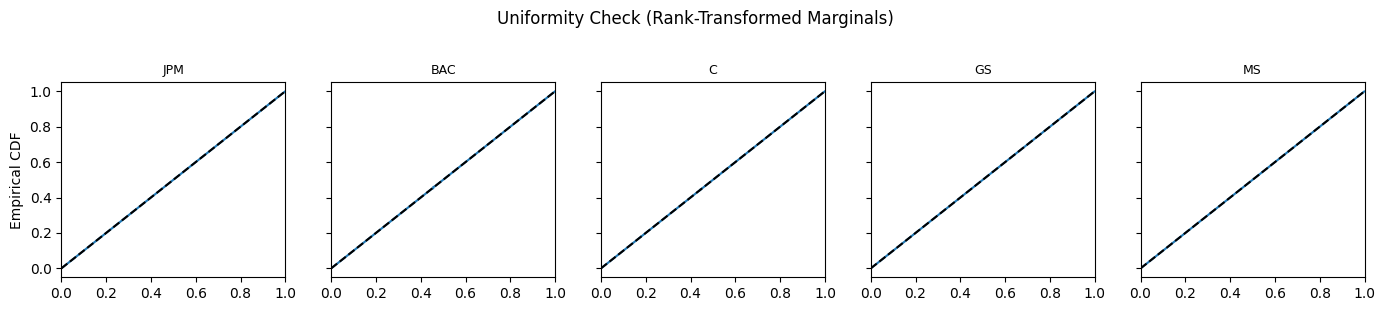

In [291]:
# Check uniformity
fig, axes = plt.subplots(1, len(tickers), figsize=(14, 3), sharey=True)

for ax, col in zip(axes, tickers):
    u = u_joint_df[col].values
    u_sorted = np.sort(u)
    n = len(u_sorted)
    
    ax.plot(u_sorted, np.arange(1, n + 1) / (n + 1), label='Empirical')
    ax.plot([0, 1], [0, 1], 'k--', label='Uniform')
    ax.set_title(col, fontsize=9)
    ax.set_xlim(0, 1)

axes[0].set_ylabel('Empirical CDF')
fig.suptitle('Uniformity Check (Rank-Transformed Marginals)', y=1.02)
plt.tight_layout()
plt.savefig(f"output/{FIG_OUTPUT_DIR}/uniformity_check.png", dpi=150)
plt.show()

In [292]:
# Fit Gaussian copula - estimates correlation via rank correlation
# Fit t-copula - estimates correlation + degrees of freedom using MLE

copula_model = COPULA

if COPULA == 'gaussian':
    copula = GaussianCopula().fit(u_joint_df.values)
elif COPULA == 't':
    copula = TCopula(df=DF_OVERRIDE).fit(u_joint_df.values)
else:
    raise ValueError("Invalid COPULA type. Choose 'gaussian' or 't'.")

print(f'{COPULA.capitalize()} Copula Fit Results')
print('=' * 50)
print("Calibrated Correlation Matrix (same for Gaussian and t-copula):")
corr_df = pd.DataFrame(
    copula.correlation_matrix,
    index=tickers,
    columns=tickers
)
display(corr_df.style.format("{:.3f}"))

if COPULA == 't':
    # t-copula results
    print(f"\nt-Copula Degrees of Freedom: {copula.df:.2f}")
    if copula.fit_result_ is not None:
        print(f"Log-Likelihood at optimum: {copula.fit_result_.log_likelihood:.2f}")
    else:
        print("(Degrees of freedom was user-specified, MLE skipped)")
else:
    pass

# Save down the calibrated correlation matrix
corr_df.to_csv(f"output/{FIG_OUTPUT_DIR}/calibrated_correlation_matrix_{COPULA}.csv")

T Copula Fit Results
Calibrated Correlation Matrix (same for Gaussian and t-copula):


,JPM,BAC,C,GS,MS
JPM,1.000,0.749,0.735,0.734,0.694
BAC,0.749,1.000,0.755,0.684,0.691
C,0.735,0.755,1.000,0.727,0.706
GS,0.734,0.684,0.727,1.000,0.842
MS,0.694,0.691,0.706,0.842,1.000



t-Copula Degrees of Freedom: 3.95
Log-Likelihood at optimum: 1162.28


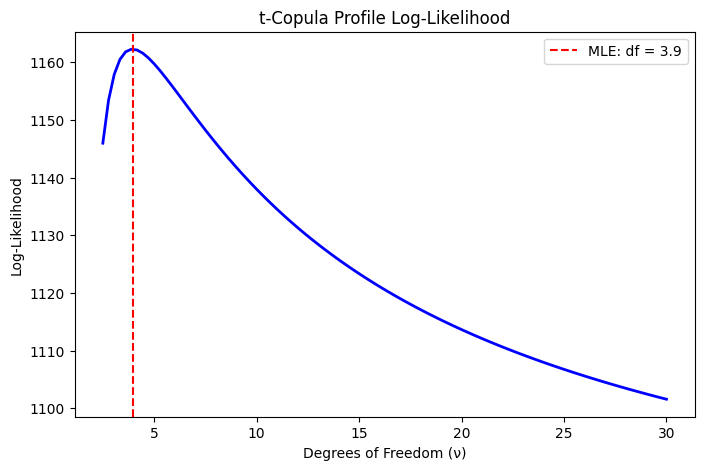

Optimal df: 3.95
Max log-likelihood: 1162.28


In [308]:
if COPULA == 't' and copula.fit_result_ is not None:

    # Generate LLH vs df curve
    df_range = np.linspace(2.5, 30, 100)
    llh_values = [copula.log_likelihood(df) for df in df_range]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(df_range, llh_values, 'b-', linewidth=2)
    ax.axvline(copula.df, color='r', linestyle='--', label=f'MLE: df = {copula.df:.1f}')
    ax.set_xlabel('Degrees of Freedom (ν)')
    ax.set_ylabel('Log-Likelihood')
    ax.set_title('t-Copula Profile Log-Likelihood')
    ax.legend()
    plt.savefig(f"output/{FIG_OUTPUT_DIR}/t_copula_llh_profile.png", dpi=150)
    plt.show()

    print(f"Optimal df: {copula.df:.2f}")
    print(f"Max log-likelihood: {copula.fit_result_.log_likelihood:.2f}")

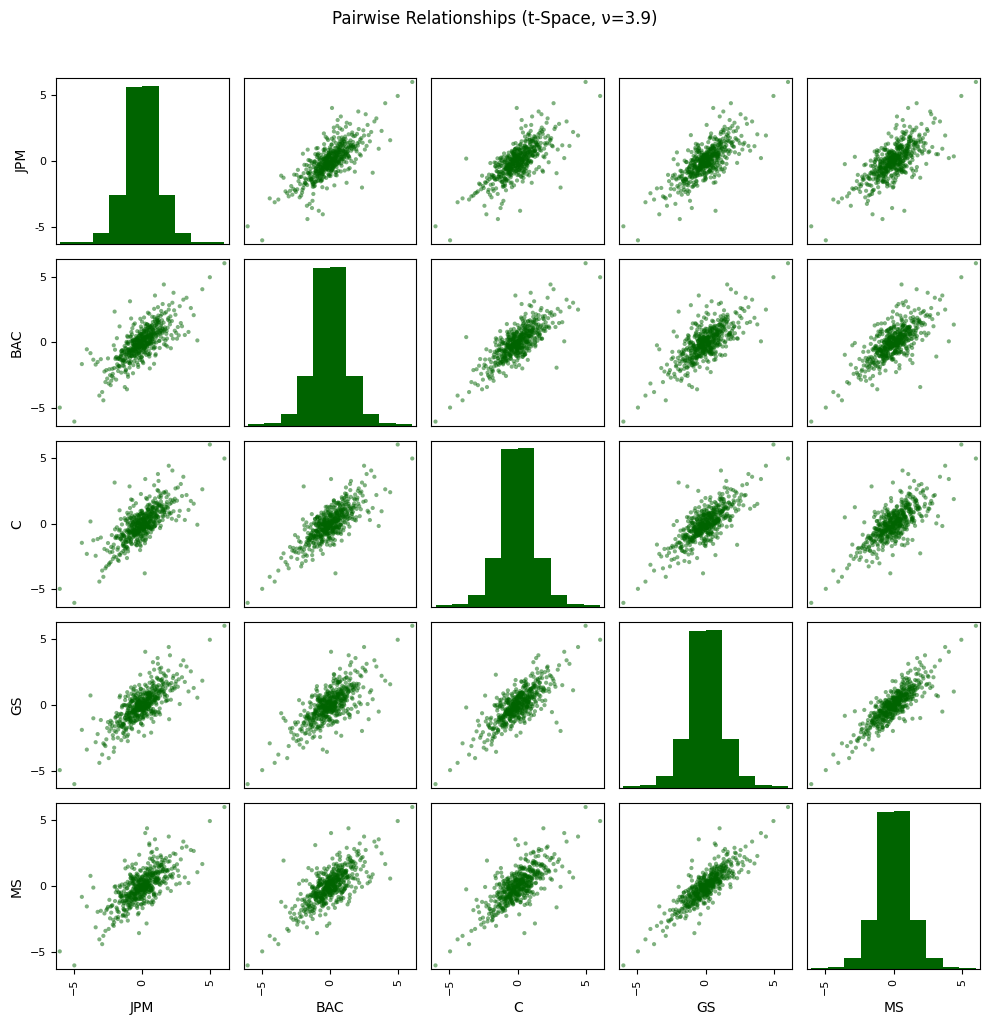

In [294]:
# Visualize dependence in normal/t space (for diagnostics)
z_df = pd.DataFrame(
    norm.ppf(u_joint_df) if COPULA == 'gaussian' else t.ppf(u_joint_df, df=copula.df),
    columns=u_joint_df.columns,
    index=u_joint_df.index
)
title = 'Pairwise Relationships (Normal Space)' if COPULA == 'gaussian' else f'Pairwise Relationships (t-Space, ν={copula.df:.1f})'
plot_scatter_matrix(z_df, title=title)

## 6. Hazard Rate Bootstrapping

In [295]:
# Load current CDS curves
curve_path = config.DATA_PATHS[DATA_MODE]['current']
print(f"Loading current CDS curves from: {curve_path}")

current_curves_df = (
    pd.read_csv(curve_path)
    .loc[lambda df: df['ticker'].isin(tickers)]
    .pivot(
        index='ticker',
        columns='tenor_years',
        values='cds_spread_bps'
    )
)

print("Current CDS Curves (bps):")
display(current_curves_df)

# Save down current curves
current_curves_df.to_csv(f"output/{FIG_OUTPUT_DIR}/current_cds_curves.csv")

Loading current CDS curves from: data/real/synthetic_cds_curves.csv
Current CDS Curves (bps):


tenor_years,1,2,3,4,5
ticker,,,,,
BAC,13.5,22.4,28.5,32.6,35.0
C,32.8,54.4,69.2,79.1,85.0
GS,46.3,76.8,97.7,111.7,120.0
JPM,21.2,35.2,44.8,51.2,55.0
MS,17.4,28.8,36.7,41.9,45.0


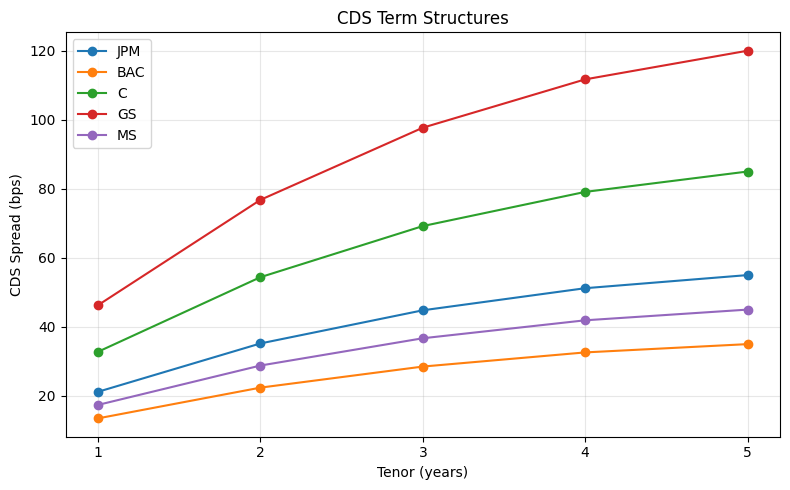

In [296]:
# Visualize CDS term structures
tenors = current_curves_df.columns.values

fig, ax = plt.subplots(figsize=(8, 5))
for ticker in tickers:
    ax.plot(tenors, current_curves_df.loc[ticker], marker='o', label=ticker)

ax.set_xlabel('Tenor (years)')
ax.set_ylabel('CDS Spread (bps)')
ax.set_title('CDS Term Structures')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xticks(tenors)
plt.tight_layout()
plt.savefig(f"output/{FIG_OUTPUT_DIR}/cds_term_structure.png", dpi=150)
plt.show()

In [297]:
# Bootstrap hazard rates
hazard_rates = pd.DataFrame(
    index=tickers,
    columns=tenors,
    dtype=float
)

for ticker in tickers:
    spreads = current_curves_df.loc[ticker].values
    bootstrapper = BootStrapper(tenors, spreads, recovery_rate=RECOVERY_RATE)
    hazard_rates.loc[ticker] = bootstrapper.bootstrap()

print("Bootstrapped Hazard Rates (per year):")
display(hazard_rates)

# Save down hazard rates
hazard_rates.to_csv(f"output/{FIG_OUTPUT_DIR}/bootstrapped_hazard_rates.csv")

Bootstrapped Hazard Rates (per year):


,1,2,3,4,5
JPM,0.003533,0.008200,0.010667,0.011733,0.011700
BAC,0.002250,0.005217,0.006783,0.007483,0.007433
C,0.005467,0.012667,0.016467,0.018133,0.018100
GS,0.007717,0.017883,0.023250,0.025617,0.025533
MS,0.002900,0.006700,0.008750,0.009583,0.009567


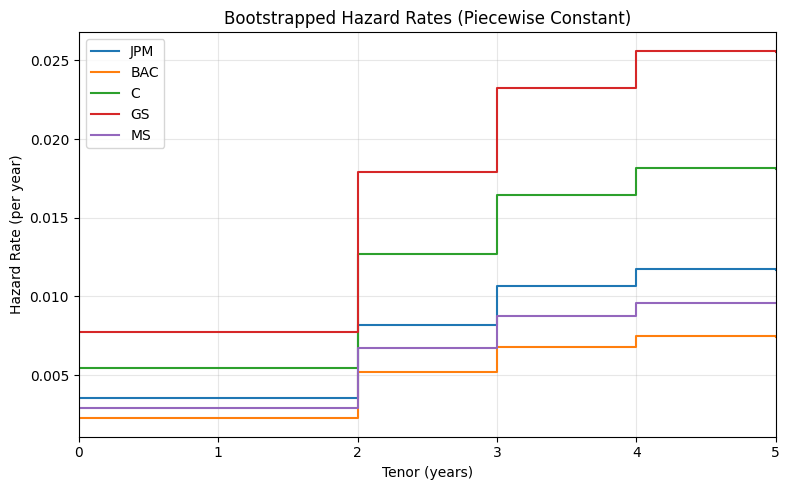

In [298]:
# Visualize hazard rates (step-wise)
fig, ax = plt.subplots(figsize=(8, 5))

for ticker in tickers:
    h = hazard_rates.loc[ticker].values
    time_grid = np.concatenate([[0], tenors])
    h_step = np.concatenate([[h[0]], h])  # Extend first rate to t=0
    ax.step(time_grid, h_step, where='post', label=ticker, linewidth=1.5)

ax.set_xlabel('Tenor (years)')
ax.set_ylabel('Hazard Rate (per year)')
ax.set_title('Bootstrapped Hazard Rates (Piecewise Constant)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xlim(0, tenors[-1])
plt.tight_layout()
plt.savefig(f"output/{FIG_OUTPUT_DIR}/hazard_rates.png", dpi=150)
plt.show()

## 7. Monte Carlo Simulation

In [299]:
# Simulate correlated uniforms from fitted copula
U_sim = copula.simulate(N_SIMS, rng=rng)

U_sim_df = pd.DataFrame(U_sim, columns=tickers)
print(f"Simulated uniforms shape: {U_sim_df.shape}")
display(U_sim_df.head())

d:\cqf-cds-pricing\.venv\lib\site-packages\scipy\stats\_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


Simulated uniforms shape: (100000, 5)


,JPM,BAC,C,GS,MS
0,0.424500,0.691119,0.760989,0.213184,0.252459
1,0.660815,0.408814,0.188623,0.464126,0.628792
2,0.770218,0.754989,0.751698,0.673183,0.725396
3,0.040022,0.053712,0.040182,0.169107,0.019575
4,0.139760,0.350643,0.112370,0.813621,0.384994


In [300]:
# Convert uniforms to default times
ttd_arr = np.zeros((N_SIMS, len(tickers)))

for j, ticker in enumerate(tickers):
    h = hazard_rates.loc[ticker].values
    t = tenors
    
    for i in range(N_SIMS):
        u = U_sim_df.iloc[i, j]
        ttd_arr[i, j] = time_to_default(u, h, t)

ttd_df = pd.DataFrame(ttd_arr, columns=tickers)
print(f"Time-to-default shape: {ttd_df.shape}")
display(ttd_df.head())

Time-to-default shape: (100000, 5)


,JPM,BAC,C,GS,MS
0,inf,inf,inf,inf,inf
1,inf,inf,inf,inf,inf
2,inf,inf,inf,inf,inf
3,4.573648,inf,3.353597,inf,3.148104
4,inf,inf,inf,inf,inf


In [301]:
# Extract k-th default time
kth_default_times = kth_to_default_df(ttd_df, tickers, k=K)

# Count defaults within term
n_defaults = (kth_default_times <= TERM).sum()
print(f"{K}-th default occurs within {TERM}Y in {n_defaults:,} / {N_SIMS:,} simulations ({100*n_defaults/N_SIMS:.2f}%)")
display(pd.DataFrame(kth_default_times, columns=[f'{K}-th_default_time']))

5-th default occurs within 5.0Y in 4,388 / 100,000 simulations (4.39%)


,5-th_default_time
0,inf
1,inf
2,inf
3,inf
4,inf
...,...
99995,inf
99996,inf
99997,inf
99998,inf


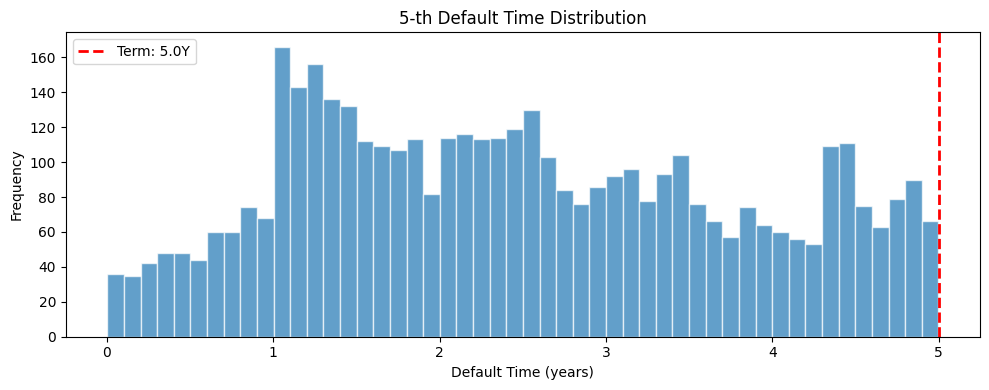

In [302]:
# Default time distribution
finite_times = kth_default_times[kth_default_times < np.inf]

if len(finite_times) > 0:
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.hist(finite_times, bins=50, edgecolor='white', alpha=0.7)
    ax.axvline(TERM, color='red', linestyle='--', linewidth=2, label=f'Term: {TERM}Y')
    ax.set_xlabel('Default Time (years)')
    ax.set_ylabel('Frequency')
    ax.set_title(f'{K}-th Default Time Distribution')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"output/{FIG_OUTPUT_DIR}/default-time-distribution_{COPULA}.png")
    plt.show()
else:
    print("No defaults in simulation.")

## 8. CDS Pricing

In [303]:
# Price k-th to default CDS
pricer = CDSPricing(
    time_to_default=kth_default_times,
    term=TERM,
    recovery_rate=RECOVERY_RATE
)

fair_spread = pricer.price()
is_antithetic = (RNG_METHOD == 'pseudo_antithetic')
se = pricer.se_price(is_antithetic=is_antithetic)

print(f"\n{'='*50}")
print(f"  {K}-th to Default CDS Fair Spread: {fair_spread:.2f} bps")
print(f"  Standard Error: {se:.4f} bps")
print(f"{'='*50}")

# Record result for papermill/scrapbook
import scrapbook as sb
sb.glue('fair_spread', fair_spread, display=False)
sb.glue('se_bps', se, display=False)
sb.glue('K', K, display=False)
sb.glue('COPULA', COPULA, display=False)
sb.glue('RNG_METHOD', RNG_METHOD, display=False)
sb.glue('N_SIMS', N_SIMS, display=False)
sb.glue('kth_default_times', kth_default_times.tolist(), display=False)
sb.glue('n_defaults_in_term', int((kth_default_times <= TERM).sum()), display=False)


  5-th to Default CDS Fair Spread: 53.84 bps
  Standard Error: 0.8127 bps


d:\cqf-cds-pricing\.venv\lib\site-packages\jupyter_client\session.py:727: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


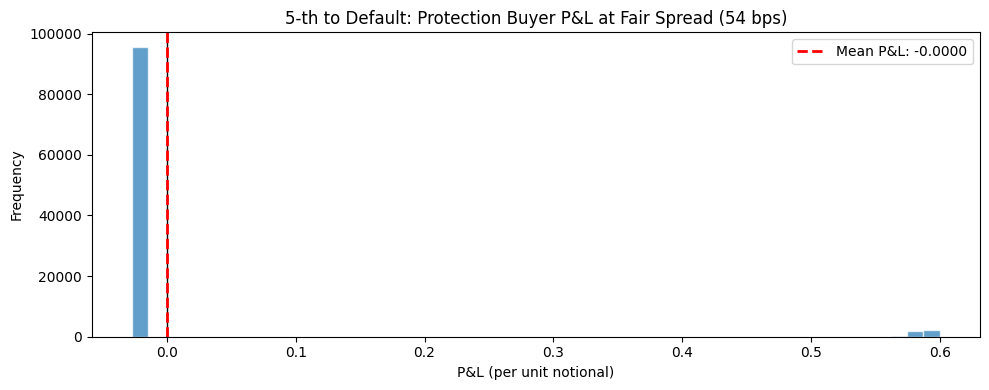

Mean P&L: -0.000000 (should be ~0 at fair spread)
Std P&L: 0.1257


In [304]:
# P&L distribution (protection buyer perspective at fair spread)
# P&L = payout received - premium paid
payout = pricer._default_leg()
unit_premium = pricer._unit_premium_leg()
premium_paid = (fair_spread / 10000) * unit_premium  # Convert bps back to decimal
pnl = payout - premium_paid

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(pnl, bins=50, edgecolor='white', alpha=0.7)
ax.axvline(0, color='black', linestyle='-', linewidth=1)
ax.axvline(pnl.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean P&L: {pnl.mean():.4f}')
ax.set_xlabel('P&L (per unit notional)')
ax.set_ylabel('Frequency')
ax.set_title(f'{K}-th to Default: Protection Buyer P&L at Fair Spread ({fair_spread:.0f} bps)')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Mean P&L: {pnl.mean():.6f} (should be ~0 at fair spread)")
print(f"Std P&L: {pnl.std():.4f}")

## 9. Results Summary

In [305]:
# Summary table
copula_str = COPULA if COPULA == 'gaussian' else f't (ν={copula.df:.1f})'
summary = {
    'Parameter': ['Basket Size', 'Correlation','k-th to Default', 'Term', 'Recovery Rate', 'Simulations', 'Copula', 'RNG Method', 'Fair Spread (bps)'],
    'Value': [len(tickers), f'{CORR_LEVEL}', K, f'{TERM}Y', f'{RECOVERY_RATE:.0%}', f'{N_SIMS:,}', copula_str, RNG_METHOD, f'{fair_spread:.2f}']
}
summary_df = pd.DataFrame(summary)

print("Pricing Parameters:")
display(summary_df)

# Save down summary
summary_df.to_csv(f"output/{FIG_OUTPUT_DIR}/pricing_summary_{COPULA}.csv", index=False)

Pricing Parameters:


,Parameter,Value
0,Basket Size,5
1,Correlation,high
2,k-th to Default,5
3,Term,5.0Y
4,Recovery Rate,40%
5,Simulations,"100,000"
6,Copula,t (ν=3.9)
7,RNG Method,sobol
8,Fair Spread (bps),53.84


In [306]:
SAVE_CSV = False        # Set to True to save results to CSV

In [307]:
if SAVE_CSV:
    # Export scenario-wise results for further analysis
    pd.concat(
        [
            ttd_df,
            pd.DataFrame({
                f'{K}th_default_times': kth_default_times,
            })
        ],
        axis=1
    ).to_csv('output/scenarios.csv', index=False)